<a href="https://colab.research.google.com/github/rath772k/Machine-learning-problems/blob/master/Image_coloring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
import numpy as np
import cv2
import tensorflow as tf
import skimage.color as color
import skimage.io as io
from keras.layers import *
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import sklearn
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
x_t = color.rgb2lab(x_train/255)
x_tes = color.rgb2lab(x_test/255)
x_t = x_t[:,:,:,0:1]
x_tes = x_tes[:,:,:,0:1]

In [ ]:
input_img = Input(shape=(32, 32, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)

W0812 06:03:51.121936 139656852563840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 06:03:51.164887 139656852563840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 06:03:51.173327 139656852563840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 06:03:51.201730 139656852563840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0812 06:03:51.229768 139656852563840 deprecation_wrapp

In [ ]:
def _preprocess_padding(padding):
    """Convert keras' padding to tensorflow's padding.
    # Arguments
        padding: string, `"same"` or `"valid"`.
    # Returns
        a string, `"SAME"` or `"VALID"`.
    # Raises
        ValueError: if `padding` is invalid.
    """
    if padding == 'same':
        padding = 'SAME'
    elif padding == 'valid':
        padding = 'VALID'
    else:
        raise ValueError('Invalid padding:', padding)
    return padding

In [ ]:
def extract_image_patches(x, ksizes, ssizes, padding='same',
                          data_format='channels_last'):
    """Extract the patches from an image.
    # Arguments
        x: The input image
        ksizes: 2-d tuple with the kernel size
        ssizes: 2-d tuple with the strides size
        padding: 'same' or 'valid'
        data_format: 'channels_last' or 'channels_first'
    # Returns
        The (k_w,k_h) patches extracted
        TF ==> (batch_size,w,h,k_w,k_h,c)
        TH ==> (batch_size,w,h,c,k_w,k_h)
    """
    kernel = [1, ksizes[0], ksizes[1], 1]
    strides = [1, ssizes[0], ssizes[1], 1]
    padding = _preprocess_padding(padding)
    if data_format == 'channels_first':
        x = K.permute_dimensions(x, (0, 2, 3, 1))
    bs_i, w_i, h_i, ch_i = K.int_shape(x)
    patches = tf.extract_image_patches(x, kernel, strides, [1, 1, 1, 1],
                                       padding)
    bs, w, h, ch = K.int_shape(patches)
    reshaped = tf.reshape(patches, [-1, w, h, tf.floordiv(ch, ch_i), ch_i])
    final_shape = [-1, w, h, ch_i, ksizes[0], ksizes[1]]
    patches = tf.reshape(tf.transpose(reshaped, [0, 1, 2, 4, 3]), final_shape)
    if data_format == 'channels_last':
        patches = K.permute_dimensions(patches, [0, 1, 2, 4, 5, 3])
    return patches

In [ ]:
class DSSIMObjective:
    """Difference of Structural Similarity (DSSIM loss function).
    Clipped between 0 and 0.5
    Note : You should add a regularization term like a l2 loss in addition to this one.
    Note : In theano, the `kernel_size` must be a factor of the output size. So 3 could
           not be the `kernel_size` for an output of 32.
    # Arguments
        k1: Parameter of the SSIM (default 0.01)
        k2: Parameter of the SSIM (default 0.03)
        kernel_size: Size of the sliding window (default 3)
        max_value: Max value of the output (default 1.0)
    """

    def __init__(self, k1=0.01, k2=0.03, kernel_size=3, max_value=1.0):
        self.__name__ = 'DSSIMObjective'
        self.kernel_size = kernel_size
        self.k1 = k1
        self.k2 = k2
        self.max_value = max_value
        self.c1 = (self.k1 * self.max_value) ** 2
        self.c2 = (self.k2 * self.max_value) ** 2
        self.dim_ordering = K.image_data_format()
        self.backend = K.backend()

    def __int_shape(self, x):
        return K.int_shape(x) if self.backend == 'tensorflow' else K.shape(x)

    def __call__(self, y_true, y_pred):
        
        kernel = [self.kernel_size, self.kernel_size]
        y_true = K.reshape(y_true, [-1] + list(self.__int_shape(y_pred)[1:]))
        y_pred = K.reshape(y_pred, [-1] + list(self.__int_shape(y_pred)[1:]))

        patches_pred = extract_image_patches(y_pred, kernel, kernel, 'valid',
                                                self.dim_ordering)
        patches_true = extract_image_patches(y_true, kernel, kernel, 'valid',
                                                self.dim_ordering)

        # Reshape to get the var in the cells
        bs, w, h, c1, c2, c3 = self.__int_shape(patches_pred)
        patches_pred = K.reshape(patches_pred, [-1, w, h, c1 * c2 * c3])
        patches_true = K.reshape(patches_true, [-1, w, h, c1 * c2 * c3])
        # Get mean
        u_true = K.mean(patches_true, axis=-1)
        u_pred = K.mean(patches_pred, axis=-1)
        # Get variance
        var_true = K.var(patches_true, axis=-1)
        var_pred = K.var(patches_pred, axis=-1)
        # Get std dev
        covar_true_pred = K.mean(patches_true * patches_pred, axis=-1) - u_true * u_pred

        ssim = (2 * u_true * u_pred + self.c1) * (2 * covar_true_pred + self.c2)
        denom = ((K.square(u_true)
                  + K.square(u_pred)
                  + self.c1) * (var_pred + var_true + self.c2))
        ssim /= denom  # no need for clipping, c1 and c2 make the denom non-zero
        return 0.9*K.mean((1.0 - ssim) / 2.0) + 0.1 * K.mean((y_true-y_pred)**2)

In [ ]:
loss = DSSIMObjective()
autoencoder = Model(input_img, x)

In [ ]:
lrreducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-6)
ckpt = keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/weightsimg_coloring.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks = [lrreducer,ckpt]

In [ ]:
autoencoder.compile(optimizer='adam', loss=loss, metrics=['acc'])

In [ ]:
autoencoder.load_weights('/content/drive/My Drive/weightsimg_coloring.hdf5')

In [ ]:
autoencoder.fit(x_t[:40000], x_train[:40000],
                epochs=100,
                batch_size=256,
                shuffle=True,callbacks = callbacks,
                validation_data = (x_t[40000:], x_train[40000:])
                )

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 10s 261us/step - loss: 139.8102 - acc: 0.5476 - val_loss: 150.4188 - val_acc: 0.5186

Epoch 00001: val_loss improved from inf to 150.41877, saving model to /content/drive/My Drive/weightsimg_coloring.hdf5
Epoch 2/100
40000/40000 [==============================] - 9s 218us/step - loss: 139.3614 - acc: 0.5474 - val_loss: 145.2704 - val_acc: 0.5201

Epoch 00002: val_loss improved from 150.41877 to 145.27045, saving model to /content/drive/My Drive/weightsimg_coloring.hdf5
Epoch 3/100
40000/40000 [==============================] - 9s 220us/step - loss: 139.1677 - acc: 0.5476 - val_loss: 144.9393 - val_acc: 0.5136

Epoch 00003: val_loss improved from 145.27045 to 144.93930, saving model to /content/drive/My Drive/weightsimg_coloring.hdf5
Epoch 4/100
40000/40000 [==============================] - 9s 220us/step - loss: 139.3539 - acc: 0.5486 - val_loss: 146.8629 - val_acc: 0.5249

Epoc

In [ ]:
decoded_imgs = autoencoder.predict(x_tes)

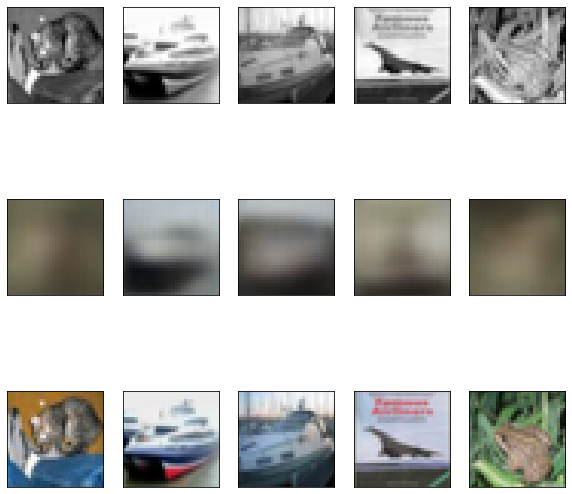

In [ ]:
n = 5
plt.figure(figsize=(10, 10))
for i in range(n):
    # display greyscale
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_tes[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n+1)
    plt.imshow(decoded_imgs[i,:,:,:]/310)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display original
    ax = plt.subplot(3, n, i + 2*n+1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print(np.max(x_test[0]))